### Find the best prediction model

#### Load libraries
The first step is to load the required libraries

In [171]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

import numpy as np

#### Load the clients database

In [172]:
clientsdf=pd.read_csv('mwc22-client_table.csv')
clientsdf.head(5)

,CLIENT ID,CLIENT_SEGMENT,AVG CONSO,AVG BASKET SIZE,RECEIVED_COMMUNICATION
0,24321771,6,"67,25","201,75",0
1,24321859,2,"58,33",350,0
2,24321880,3,"46,67",112,0
3,24321957,2,50,600,0
4,24321962,4,10,120,0


In [173]:
len(clientsdf)

35884

In [174]:
columns=['CLIENT ID', 'AVG CONSO', 'AVG BASKET SIZE', 'RECEIVED_COMMUNICATION']
target=['CLIENT_SEGMENT']

In [175]:
# Change Data Type
clientsdf['AVG CONSO']=clientsdf['AVG CONSO'].str.replace(',','.').astype(float)
clientsdf['AVG BASKET SIZE']=clientsdf['AVG BASKET SIZE'].str.replace(',','.').astype(float)

### Outliers
Check the data for outliers

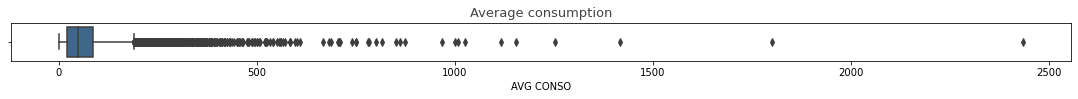

In [176]:
plt.figure(figsize=(19,0.7))
sns.boxplot(x=clientsdf["AVG CONSO"], color='#336699').set_title('Average consumption', color='#444', fontsize=13)
plt.show()

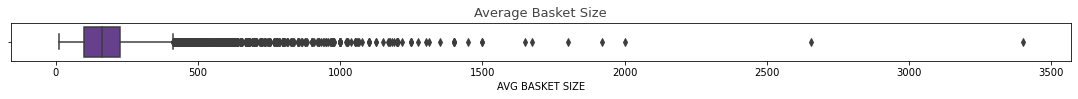

In [177]:
plt.figure(figsize=(19,0.7))
sns.boxplot(x=clientsdf["AVG BASKET SIZE"], color='#663399').set_title('Average Basket Size', color='#444', fontsize=13)
plt.show()

<br><br>To build the model, The client ID feature is not relevant therefore it cecome the index

In [178]:
clientsdf= clientsdf.set_index('CLIENT ID')
clientsdf.head(3)

,CLIENT_SEGMENT,AVG CONSO,AVG BASKET SIZE,RECEIVED_COMMUNICATION
CLIENT ID,,,,
24321771,6,67.25,201.75,0
24321859,2,58.33,350.00,0
24321880,3,46.67,112.00,0


<AxesSubplot:>

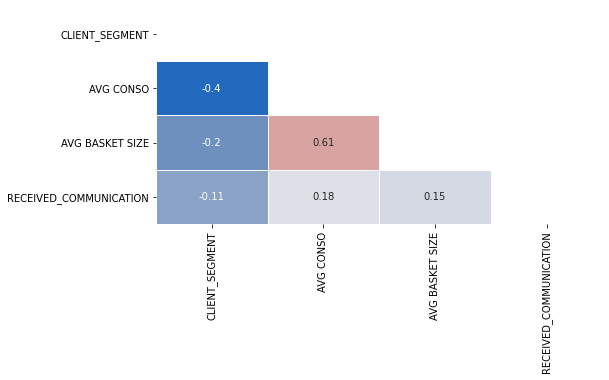

In [179]:
# check correlation to discard columns if necessary
corr = clientsdf.corr()
cmap = sns.light_palette("#0c2a70", as_cmap=True)
mask = np.triu(corr)
plt.figure(figsize=(8,4))
sns.heatmap(corr, cmap='vlag', annot=True, linewidths=0.5, center=0.3, cbar=False, xticklabels=True,mask=mask)

There is some correlation between some columns, and, as there are too little features, none will be discarted

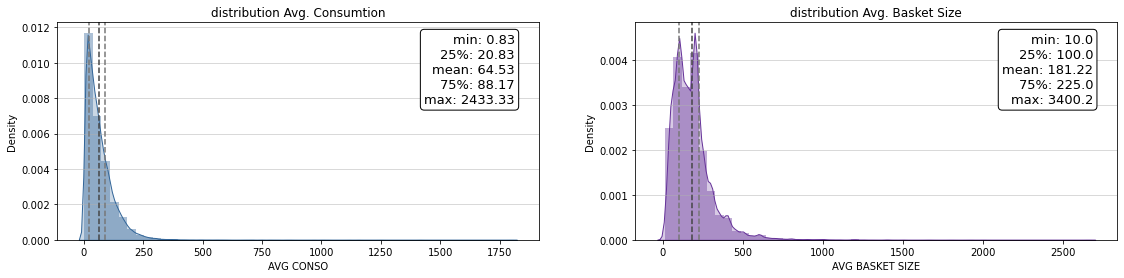

In [180]:
#DISTRIBUTION PLOT

fig, ax = plt.subplots(nrows=1, ncols=2,  sharex=False, sharey=False,figsize=(19,4))

xx,yy='AVG CONSO',"AVG BASKET SIZE"

ax[0].title.set_text('distribution Avg. Consumtion')
variable = clientsdf[xx]
breaks = np.quantile(variable, q=np.linspace(0, 1, 11))
variable = variable[ (variable > breaks[0]) & (variable < breaks[10]) ]
sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True}, ax=ax[0], color='#336699')
des = clientsdf[xx].describe()
ax[0].axvline(des["25%"], ls='--', color='#777')
ax[0].axvline(des["mean"], ls='--', color='#444')
ax[0].axvline(des["75%"], ls='--', color='#777')
ax[0].grid( axis='y', alpha=0.6)
des = round(des, 2).apply(lambda xx: str(xx))
box = '\n'.join(("min: "+des["min"], "25%: "+des["25%"], "mean: "+des["mean"], "75%: "+des["75%"], "max: "+des["max"]))
ax[0].text(0.95, 0.95, box, transform=ax[0].transAxes, fontsize=13, va='top', ha="right", bbox=dict(boxstyle='round', facecolor='white', alpha=1))

ax[1].title.set_text('distribution Avg. Basket Size')
variable = clientsdf[yy]
breaks = np.quantile(variable, q=np.linspace(0, 1, 11))
variable = variable[ (variable > breaks[0]) & (variable < breaks[10]) ]
sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True}, ax=ax[1], color='#663399')
des = clientsdf[yy].describe()
ax[1].axvline(des["25%"], ls='--', color='#777')
ax[1].axvline(des["mean"], ls='--', color='#444')
ax[1].axvline(des["75%"], ls='--', color='#777')
ax[1].grid(axis='y', alpha=0.6)
des = round(des, 2).apply(lambda yy: str(yy))
box = '\n'.join(("min: "+des["min"], "25%: "+des["25%"], "mean: "+des["mean"], "75%: "+des["75%"], "max: "+des["max"]))
ax[1].text(0.95, 0.95, box, transform=ax[1].transAxes, fontsize=13, va='top', ha="right", bbox=dict(boxstyle='round', facecolor='white', alpha=1))
plt.show()

In [181]:
#Features SKEW
clientsdf[yy].skew(),clientsdf[xx].skew()

(3.0613305104090647, 5.067529969159413)


##### <br> Process columns

In [197]:
# ML libraries
import sklearn
from sklearn.preprocessing import PowerTransformer,MinMaxScaler
from scipy import stats
from pickle import dump, load

from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [183]:
#As the features are very skewed, a Powertransformer will be applied, the method with the lowest lamda

fitted_data, fitted_lambda = stats.boxcox(clientsdf[xx])
fitted_data1, fitted_lambda1 = stats.yeojohnson(clientsdf[xx])
fitted_data2, fitted_lambda2 = stats.boxcox(clientsdf[yy])
fitted_data3, fitted_lambda3 = stats.yeojohnson(clientsdf[yy])

print('AVG CONSO: box-cox lambda:',fitted_lambda,'yeo-johnson lambda:',fitted_lambda1)
print('AVG BASKET SIZE: box-cox lambda:',fitted_lambda2,'yeo-johnson lambda:',fitted_lambda3)

AVG CONSO: box-cox lambda: 0.22249169058516302 yeo-johnson lambda: 0.19215668575507638
AVG BASKET SIZE: box-cox lambda: 0.2048747812925481 yeo-johnson lambda: 0.1971934739643877


<AxesSubplot:ylabel='Density'>

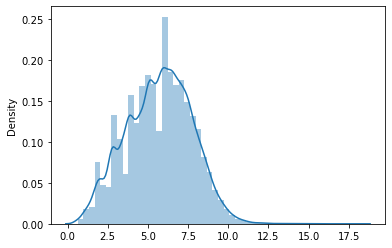

In [184]:
sns.distplot(fitted_data1)

In [185]:
powercols=['AVG CONSO',"AVG BASKET SIZE"]

In [186]:
#apply Power Transform and save model
pt = PowerTransformer(method='yeo-johnson')

pt.fit(clientsdf[powercols])
clientsdf[powercols]=pt.transform(clientsdf[powercols])

dump(pt, open('pt.pkl', 'wb'))

In [187]:
# apply MinMaxScaler and save model
scaler = MinMaxScaler()
scaler.fit(clientsdf[powercols])
clientsdf[powercols]=scaler.transform(clientsdf[powercols])

dump(scaler, open('scaler.pkl', 'wb'))

In [188]:
clientsdf.to_csv('new_clients.csv')
clientsdf.head(5)

,CLIENT_SEGMENT,AVG CONSO,AVG BASKET SIZE,RECEIVED_COMMUNICATION
CLIENT ID,,,,
24321771,6,0.336661,0.370136,0
24321859,2,0.318821,0.466923,0
24321880,3,0.291894,0.277934,0
24321957,2,0.300083,0.572494,0
24321962,4,0.137915,0.288182,0


At this moment, the table is ready to apply a classification model to predict the <b>clients segments</b><br><br><br>

### Classification models
Will try 2: RandomForestClassifier and LGBMClassifier

In [189]:
#divide columns between featrures and target

features=['AVG CONSO',"AVG BASKET SIZE",'RECEIVED_COMMUNICATION']
clientsdf = clientsdf.sample(frac =.3)
X = clientsdf[features].values
y = clientsdf['CLIENT_SEGMENT'].values

In [190]:
len(clientsdf)

10765

In [191]:
#split the database into train and test sets, in this case, stratification seems needed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(X_train.shape); print(X_test.shape)

(8612, 3)
(2153, 3)


##### Random Forest

In [192]:
# Random Forest Hiperparameters tunning with Grid Search

rfc = RandomForestClassifier(random_state=42, n_jobs=-1)

#Parameters:
fit_params={
    'n_estimators': [100, 500, 700], 'max_depth':[4,8],
    'max_features': ['auto', 'sqrt', 'log2'], 'criterion':['gini','entropy'], 
}

#'min_samples_leaf': [1, 2],'min_samples_split': [2, 5],

In [193]:
grid = GridSearchCV(estimator=rfc, param_grid=fit_params, cv= 5)

In [36]:
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [4, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 500, 700]})

In [37]:
print (grid.best_params_)

{'criterion': 'entropy', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 700}


Having the hyperparameters stablished, start building the model

In [165]:
rfc1=RandomForestClassifier(n_estimators=700, random_state=42, n_jobs=-1,
                            criterion= 'entropy', max_depth= 8,max_features= 'auto')

rfc1.fit(X_train,y_train)

y_pred=rfc1.predict(X_test)

#### Build a confusion Matrix and calculate some metrics to evaluate the model

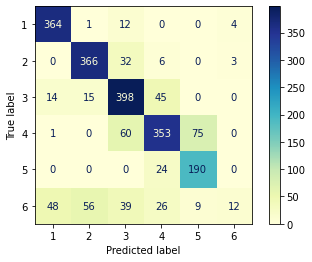

In [166]:
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=['1', '2','3','4','5','6']).plot(cmap='YlGnBu')


In [167]:
print('Accuracy: %.3f' % rfc1.score(X_test, y_test))
print('F1 Score: %.3f' % f1_score(y_test, y_pred, average='macro'))
print('Precision Score: %.3f' % precision_score(y_test, y_pred, average='macro'))

Accuracy: 0.782
F1 Score: 0.699
Precision Score: 0.754


### LGBMClassifier

In [211]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score

GridSearch

In [53]:
#Define the parameters
parameters = {'num_leaves':[20,40], 'min_child_samples':[5,10],'max_depth':[-1,1,5],
             'learning_rate':[0.1,0.2],'reg_alpha':[0,0.1]}

In [ ]:
#Parameters for a better F1 scoring
lgb=lgb.LGBMClassifier()
grid=GridSearchCV(lgb,parameters,scoring='f1')
grid.fit(X=X_train, y=y_train)
print(grid.best_params_)

from GoogleColab for F1 score -->
{'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 5, 'num_leaves': 20, 'reg_alpha': 0}

In [54]:
#Parameters for a better Accuracy
lgb=lgb.LGBMClassifier()
grid=GridSearchCV(lgb,parameters, cv=5,)
grid.fit(X=X_train, y=y_train)
print(grid.best_params_)

{'learning_rate': 0.1, 'max_depth': 5, 'min_child_samples': 5, 'num_leaves': 40, 'reg_alpha': 0.1}


In [212]:
opt_parameters = {'min_child_samples': 5,
                  'num_leaves': 80,
                  'learning_rate': 0.1,
                  'max_depth': -1,
                  'reg_alpha': 0.1}

model = lgb.LGBMClassifier(**opt_parameters)
model.fit(X_train, y_train)

expected_y  = y_test
y_pred = model.predict(X_test)

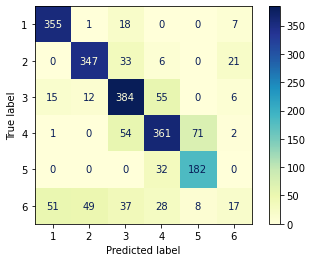

In [169]:
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=['1', '2','3','4','5','6']).plot(cmap='YlGnBu')

In [170]:
print('Accuracy: %.3f' % model.score(X_test, y_test))
print('F1 Score: %.3f' % f1_score(y_test, y_pred, average='macro'))
print('Precision Score: %.3f' % precision_score(y_test, y_pred, average='macro'))

Accuracy: 0.765
F1 Score: 0.692
Precision Score: 0.698


In [194]:
preddf=pd.read_csv('mwc22-client_table_test_x.csv')
preddf.head(5)

,CLIENT ID,AVG CONSO,AVG BASKET SIZE,RECEIVED_COMMUNICATION
0,48352078,"8,33",100,0
1,18072186,"93,42","186,83",1
2,48352246,"45,83","137,5",0
3,18070621,"16,67",200,1
4,48352262,"13,33",160,0


In [201]:
# Change Data Type
preddf['AVG CONSO']=preddf['AVG CONSO'].str.replace(',','.').astype(float)
preddf['AVG BASKET SIZE']=preddf['AVG BASKET SIZE'].str.replace(',','.').astype(float)

In [198]:
# load the model
ptmodel = load(open('pt.pkl', 'rb'))
# load the scaler
scaler = load(open('scaler.pkl', 'rb'))

In [206]:
#apply Power Transform 
ptmodel.fit(preddf[powercols])
preddf[powercols]=ptmodel.transform(preddf[powercols])


In [208]:
# apply MinMaxScaler 
scaler.fit(preddf[powercols])
preddf[powercols]=scaler.transform(preddf[powercols])

In [215]:
preddf= preddf.set_index('CLIENT ID')
preddf.head(3)

,AVG CONSO,AVG BASKET SIZE,RECEIVED_COMMUNICATION
CLIENT ID,,,
48352078,0.025268,0.293372,0
18072186,0.706128,0.576791,1
48352246,0.488643,0.431258,0


In [231]:
# make a prediction
ynew = model.predict(preddf)

In [232]:

predicciones = pd.DataFrame(data=ynew)

predicciones['CLIENT ID']=preddf.index
predicciones.rename(columns={0:'CLIENT_SEGMENT'}, inplace=True)
predicciones=predicciones[['CLIENT ID','CLIENT_SEGMENT']]
predicciones

,CLIENT ID,CLIENT_SEGMENT
0,48352078,5
1,18072186,6
2,48352246,1
3,18070621,3
4,48352262,4
5,48359553,3
6,18071647,4
7,48359574,6
8,48359627,2
9,18070505,1


In [233]:
predicciones.to_csv('results.csv')

In [94]:
#load LazyClassifier Results
lazy=pd.read_csv('wmc22_lazy.csv')
lazy

,Unnamed: 0,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
0,LGBMClassifier,0.785416,0.717505,NaN,0.756585,0.828751
1,XGBClassifier,0.780307,0.713609,NaN,0.755152,1.712106
2,LabelPropagation,0.782164,0.712735,NaN,0.752627,2.997852
3,LabelSpreading,0.780307,0.710219,NaN,0.750317,4.724608
4,ExtraTreesClassifier,0.764050,0.702207,NaN,0.746722,0.547082
5,RandomForestClassifier,0.764979,0.702444,NaN,0.745473,0.764464
6,BaggingClassifier,0.764515,0.701589,NaN,0.744382,0.152931
7,KNeighborsClassifier,0.768230,0.703416,NaN,0.744100,0.099735
8,QuadraticDiscriminantAnalysis,0.765908,0.697262,NaN,0.742108,0.023423
9,SVC,0.773340,0.703510,NaN,0.742060,1.508657
